# BB-EIT: Prediction with 5-Fold CV

Dataset: Proteins_Data_Augmented_Heteroscedastic.csv

Extended Features: Thickness, CA, ZP, pI, MW

Scaling: None

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import shap
import shap.plots as plots_util


In [76]:
CHEMBERT_MODEL = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(CHEMBERT_MODEL)
chembert = AutoModel.from_pretrained(CHEMBERT_MODEL)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chembert.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [77]:
class PolymerDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.smiles = dataframe["SMILES"].values
        self.features = dataframe[["Protein Charge (pI)", "Thickness (nm)", "Predicted CA (deg)", "Predicted Zeta (mV)", "Protein MW / kDa"]].values
        self.amount = dataframe["Protein adsorption / ng cm-2"].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.smiles[idx], return_tensors="pt", padding="max_length",
                                  truncation=True, max_length=128)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        protein_features = torch.tensor(self.features[idx], dtype=torch.float32)
        amount = torch.tensor(self.amount[idx], dtype=torch.float32)
        return input_ids, attention_mask, protein_features, amount

class ChemBERTRegressor(nn.Module):
    def __init__(self, chembert, num_features=5, hidden_dim=256):
        super(ChemBERTRegressor, self).__init__()
        self.chembert = chembert
        self.fc1 = nn.Linear(768 + num_features, hidden_dim) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)


    def forward(self, input_ids, attention_mask, protein_features, return_features=False):
        with torch.no_grad():
            outputs = self.chembert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]  
        

        holistic_feature_vector = torch.cat((pooled_output, protein_features), dim=1)
      
        if return_features:
            return holistic_feature_vector
            
        x = self.relu(self.fc1(holistic_feature_vector))
        return self.fc2(x).squeeze()

In [79]:
protein_data = pd.read_csv("Proteins_Data_Augmented_Heteroscedastic.csv")
full_df = protein_data.copy()
full_dataset = PolymerDataset(full_df, tokenizer)
full_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=False)



In [80]:
loaded_models = []
for i in range(5):
    model = ChemBERTRegressor(chembert)
    model.load_state_dict(torch.load(f"R2D2_All_All_fold_{i}.pth", map_location=device))
    model.to(device)
    model.eval()
    loaded_models.append(model)
models = loaded_models

In [81]:

def ensemble_predictor(input_tensor):

    input_tensor = torch.tensor(input_tensor, dtype=torch.float32).to(device)
    
    chemberta_embedding = input_tensor[:, :768]
    physicochemical_features = input_tensor[:, 768:]
    
    all_predictions = []
    
    for model in models:
        model.eval() 
        
        holistic_feature_vector = input_tensor 
        with torch.no_grad():

            x = model.relu(model.fc1(holistic_feature_vector))
            output = model.fc2(x).squeeze()
            
        all_predictions.append(output.cpu().numpy())
    

    return np.mean(all_predictions, axis=0)

In [82]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)
background_df = train_df.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
def get_fc_input_features(df):
    N = len(df)
    background_features = np.random.rand(len(background_df), 773) 
    return background_features

background = get_fc_input_features(background_df)

feature_groupings = [
    list(range(0, 768)), 
    [768],      
    [769],       
    [770],       
    [771],   
    [772] 
]

try:
    masker = shap.maskers.Independent(background, grouping=feature_groupings)
except TypeError:

    print("shap.maskers.Independent() does not accept 'grouping' in this shap version; using ungrouped masker.")
    masker = shap.maskers.Independent(background)

shap.maskers.Independent() does not accept 'grouping' in this shap version; using ungrouped masker.


In [95]:
X_test = get_fc_input_features(test_df)


num_features = X_test.shape[1]
min_required_evals = 2 * num_features + 1

explainer = shap.Explainer(
    ensemble_predictor,
    masker,
    output_names=["Predicted Adsorption (ng/cm\u00b2)"],
    max_evals=min_required_evals
)

shap_values = explainer(X_test)


PermutationExplainer explainer: 101it [02:18,  1.49s/it]                         


In [358]:
feature_labels = [
    'ChemBERTa Embedding',
    'Protein Charge (pI)',
    'Thickness (nm)',
    'Contact Angle (deg)',
    'Zeta Potential (mV)',
    'Protein MW (kDa)'
]


In [360]:
full_explanation = shap.Explanation(
    shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=feature_labels
)

In [151]:
mabs_chemberta = np.mean(np.sum(np.abs(shap_values.values[:, :768]), axis=1))
mabs_each_extended = np.abs(shap_values.values[:, 1:6]).mean(axis=0)

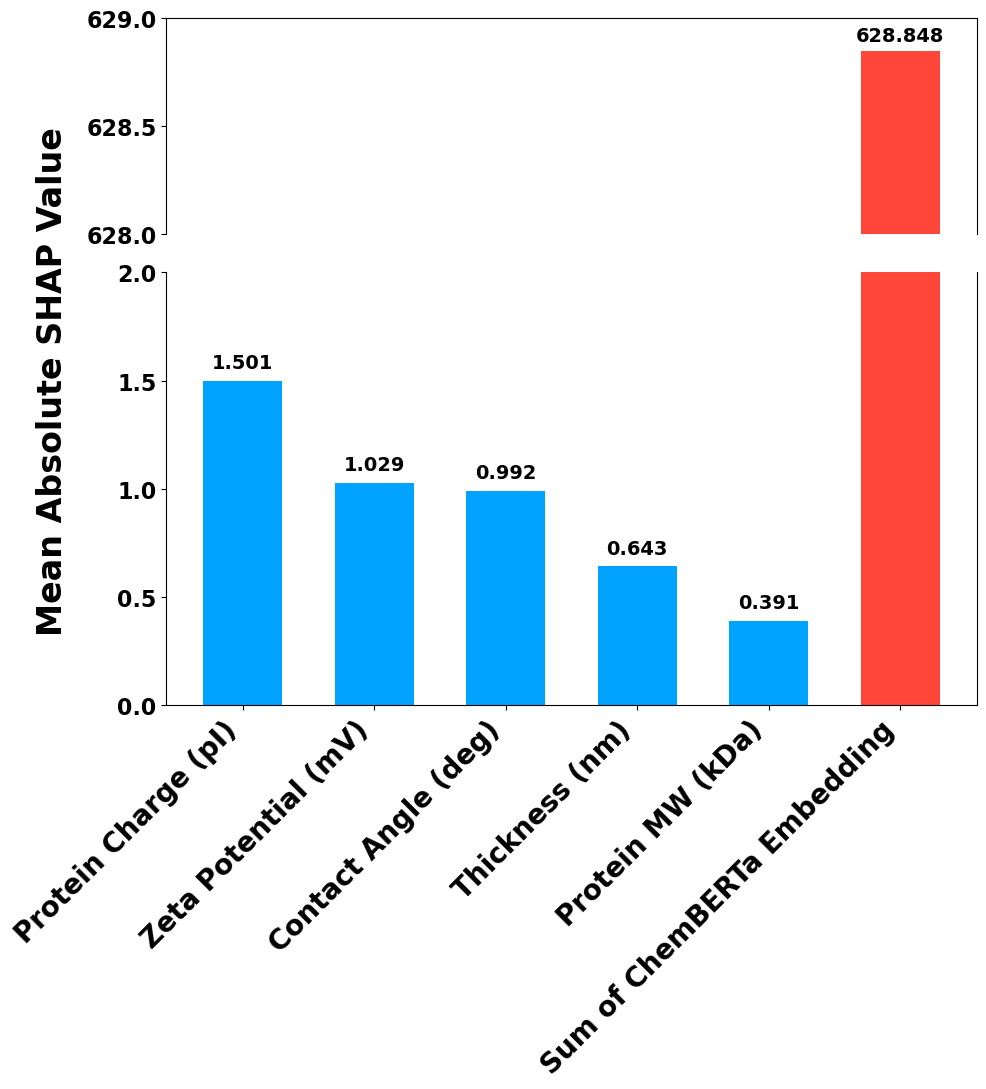

In [363]:
ext_labels = sliced_feature_names[:] 
ext_vals = mabs_each_extended.copy()
sum_label = 'Sum of ChemBERTa Embedding'
chem_val = float(mabs_chemberta)

order_desc = np.argsort(-ext_vals)
ext_labels_sorted = [ext_labels[i] for i in order_desc]
ext_vals_sorted = ext_vals[order_desc]

labels_ordered = ext_labels_sorted + [sum_label]
values_ordered = np.concatenate([ext_vals_sorted, np.array([chem_val])])

x = np.arange(len(labels_ordered))
n = len(labels_ordered)

#colors = ["#FF0051"]
colors = ["#00A3FF"] * (n - 1) + ["#FF4639"]

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True,
                                        gridspec_kw={'height_ratios': [1, 2]},
                                        figsize=(10, 11))


bar_width = 0.6

ax_top.bar(x, values_ordered, color=colors, width=bar_width, align='center')
ax_bottom.bar(x, values_ordered, color=colors, width=bar_width, align='center')

ax_bottom.set_ylim(0, 2)
ax_top.set_ylim(628, 629)

ax_bottom.set_yticks(np.linspace(0, 2, 5))
ax_top.set_yticks(np.linspace(628, 629, 3))

ax_top.spines['bottom'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_top.set_xticks([])
ax_top.set_xticklabels([])
ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax_top.set_yticklabels([f'{tick:.1f}' for tick in ax_top.get_yticks()], fontsize=16, fontweight='bold')
ax_bottom.set_yticklabels([f'{tick:.1f}' for tick in ax_bottom.get_yticks()], fontsize=16, fontweight='bold')

ax_bottom.set_xticks(x)
ax_bottom.set_xticklabels(labels_ordered, rotation=45, ha='right', fontsize=20, fontweight='bold')

ax_bottom.set_ylabel('Mean Absolute SHAP Value', fontsize=24, fontweight='bold')
ax_bottom.yaxis.set_label_coords(-0.12, 0.75)

for i, v in enumerate(values_ordered):
    if i == len(values_ordered) - 1:  
        ax_top.text(i, v + 0.03, f'{v:.3f}', ha='center', va='bottom', fontsize=14, fontweight='bold')
    else:
        ax_bottom.text(i, v + 0.04, f'{v:.3f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
